In [1]:
import os
import sys


sys.path.append(os.path.dirname(os.getcwd()))

import matplotlib.pyplot as plt
import numpy as np

from bayes_opt import BayesianOptimization

from src.utils.dataset import train_test_load
from src.utils.checkpoint import save_params, save_variational

from src.model.train import train_base
from src.model.train import train_feat
from src.model.train import train_variational

In [2]:
test_split = 0.2

train, test, metadata = train_test_load(
    "../data/ml-32m/ratings.csv",
    "../data/ml-32m/movies.csv",
    test_split=test_split,
    include_features=True
)

### Training

In [3]:
# @title Utils

def display_results(results, save_path = None):
    
    print(" Results ".center(50, "#"))
    print("Train Loss:", results["train_loss"][-1])
    print("Test Loss:", results["val_loss"][-1])
    print("Train RMSE:", results["train_rmse"][-1])
    print("Test RMSE:", results["val_rmse"][-1])
    print("#" * 50)

    fig, axs = plt.subplots(2, 1, figsize=(8, 8))

    axs[0].plot(results["train_loss"], label="Train loss")
    axs[0].plot(results["val_loss"], color="forestgreen", label="Test loss")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Loss at each iteration")
    axs[0].grid(True, linestyle=":")
    axs[0].legend()

    axs[1].plot(results["train_rmse"], label="Train RMSE")
    axs[1].plot(results["val_rmse"], color="forestgreen", label="Test RMSE")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("RMSE")
    axs[1].set_title("RMSE at each iteration")
    axs[1].grid(True, linestyle=":")
    axs[1].legend()

    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path, format="pdf", bbox_inches='tight')

    plt.show()
    

#### Hyperparameter Search

In [8]:
pbounds = {'r_lambda': (0.001, 10.0), 'r_gamma': (0.001, 10.0), 'r_tau': (0.001, 10.0)}

def objective_function(r_lambda, r_gamma, r_tau):
    output = train_base(
        train=train, val=test, n_iter=20, embedding_dim=2,
        r_lambda=r_lambda, r_gamma=r_gamma, r_tau=r_tau
    )

    return -output["val_rmse"][-1]

optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    verbose=2,
    random_state=42,
)

optimizer.maximize(
    init_points=5,
    n_iter=20,
)

|   iter    |  target   | r_lambda  |  r_gamma  |   r_tau   |
-------------------------------------------------------------
| 1         | -0.821246 | 3.7460266 | 9.5071923 | 7.3202074 |
| 2         | -0.815357 | 5.9869861 | 1.5610303 | 1.5607892 |
| 3         | -0.834622 | 0.5817780 | 8.6618952 | 6.0115490 |
| 4         | -0.814867 | 7.0810177 | 0.2068243 | 9.6991286 |
| 5         | -0.815700 | 8.3245939 | 2.1241787 | 1.8190678 |
| 6         | -0.816478 | 7.0939402 | 0.001     | 5.5191927 |
| 7         | -0.815192 | 9.2142658 | 4.7117011 | 8.3657265 |
| 8         | -0.817141 | 9.5154724 | 10.0      | 10.0      |
| 9         | -0.816333 | 10.0      | 8.4304468 | 3.4107842 |
| 10        | -0.815365 | 1.7912361 | 0.001     | 10.0      |
| 11        | -0.817467 | 0.0803714 | 0.001     | 0.001     |
| 12        | -0.815178 | 5.2020775 | 3.9283619 | 10.0      |
| 13        | -0.833573 | 6.8553153 | 6.5106176 | 0.001     |
| 14        | -0.814847 | 2.4706667 | 0.001     | 5.5303662 |
| 15    

In [16]:
optimizer.max['params']

{'r_lambda': np.float64(7.671453530098819),
 'r_gamma': np.float64(3.411014661998411),
 'r_tau': np.float64(5.16918362929313)}

In [ ]:
best_hyper_params = None

try:
    best_hyper_params = optimizer.max['params']
except Exception as _:
    best_hyper_params = {
        'r_lambda': np.float64(7.671453530098819),
        'r_gamma': np.float64(3.411014661998411),
        'r_tau': np.float64(5.16918362929313)
    }


#### Bias Only Model

#################### Results #####################
Train Loss: 73535471.39017472
Test Loss: 21252255.978222355
Train RMSE: 0.8459086861234003
Test RMSE: 0.856017552352993
##################################################


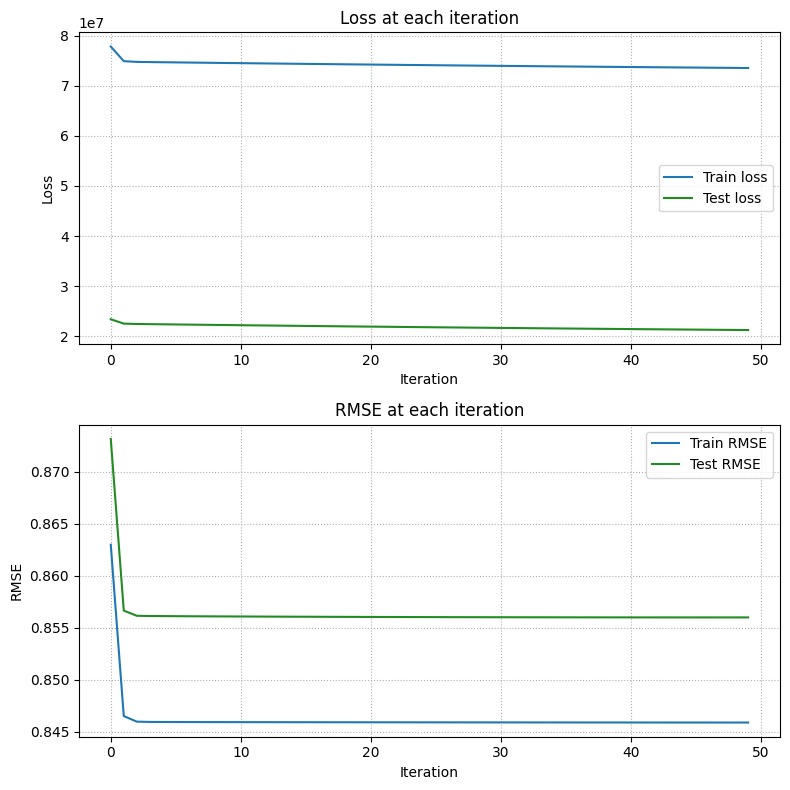

In [5]:
hyper_params = {'embedding_dim': 0, **best_hyper_params}

results = train_base(
    train,
    test,
    n_iter = 50,
    **hyper_params,
)

display_results(results, "../artifacts/plot/32m_training_bias_only.pdf")

save_params(
    "../artifacts/model/32m_users_training_bias_only", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    metadata.idx_to_user_id,
    metadata.idx_to_movie_id,
    **results["embeddings"]
)

#### Embedding Dimension Search

In [16]:
embeddings = list(range(0, 35, 5))
results_train_rmse = []
results_train_loss = []
results_test_rmse = []
results_test_loss = []

for e in embeddings:
    hyper_params = {'embedding_dim': e, **best_hyper_params}

    results = train_base(
        train,
        test,
        n_iter = 50,
        **hyper_params,
    )

    results_train_rmse.append(results["train_rmse"][-1])
    results_train_loss.append(results["train_loss"][-1])
    results_test_rmse.append(results["val_rmse"][-1])
    results_test_loss.append(results["val_loss"][-1])

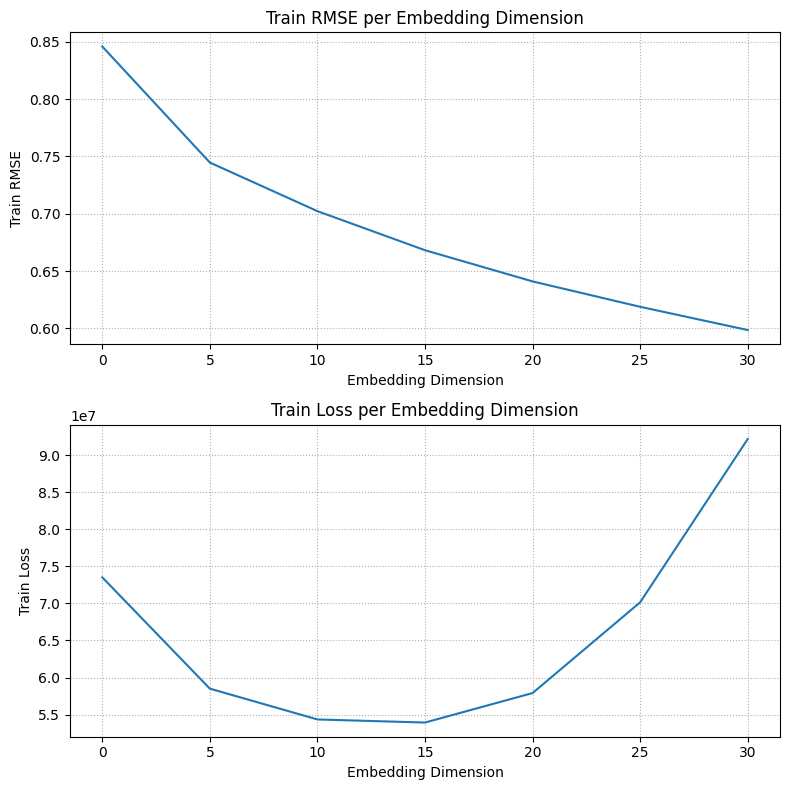

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(embeddings, results_train_rmse)
axs[0].set_xlabel("Embedding Dimension")
axs[0].set_ylabel("Train RMSE")
axs[0].set_title("Train RMSE per Embedding Dimension")
axs[0].grid(True, linestyle=":")

axs[1].plot(embeddings, results_train_loss)
axs[1].set_xlabel("Embedding Dimension")
axs[1].set_ylabel("Train Loss")
axs[1].set_title("Train Loss per Embedding Dimension")
axs[1].grid(True, linestyle=":")

plt.tight_layout()
plt.savefig("../artifacts/plot/embedding_search.pdf", format="pdf", bbox_inches='tight')
plt.show()

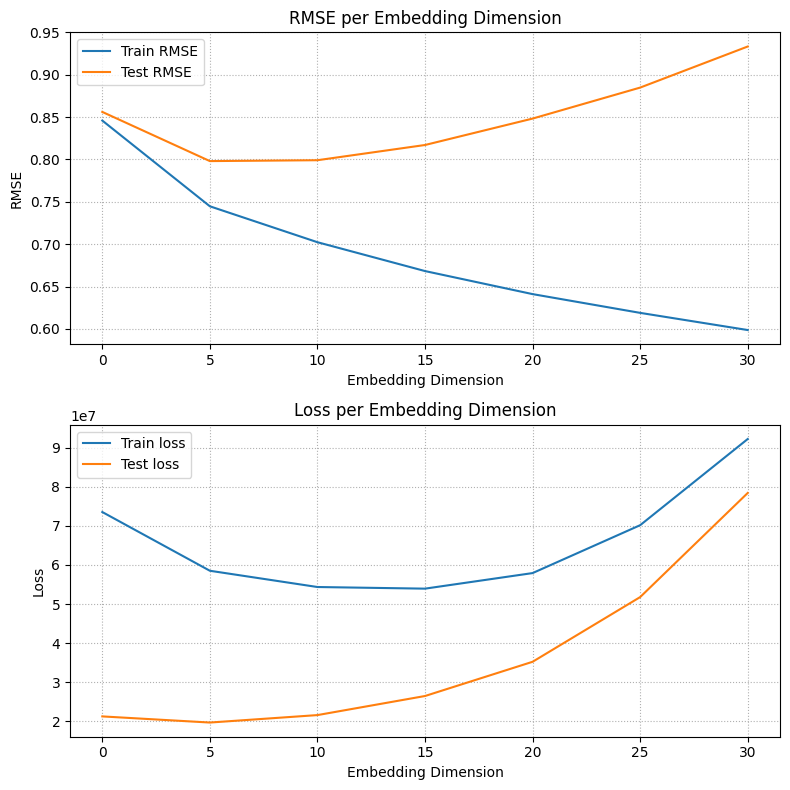

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(embeddings, results_train_rmse, label="Train RMSE")
axs[0].plot(embeddings, results_test_rmse, label="Test RMSE")
axs[0].set_xlabel("Embedding Dimension")
axs[0].set_ylabel("RMSE")
axs[0].set_title("RMSE per Embedding Dimension")
axs[0].legend()
axs[0].grid(True, linestyle=":")

axs[1].plot(embeddings, results_train_loss, label="Train loss")
axs[1].plot(embeddings, results_test_loss, label="Test loss")
axs[1].set_xlabel("Embedding Dimension")
axs[1].set_ylabel("Loss")
axs[1].set_title("Loss per Embedding Dimension")
axs[1].legend()
axs[1].grid(True, linestyle=":")

plt.tight_layout()
plt.savefig("../artifacts/plot/embedding_search_alt.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Base Model Training

############# Embedding Dimension 2 ##############
#################### Results #####################
Train Loss: 64289628.55050892
Test Loss: 19913705.609055102
Train RMSE: 0.7860028762101228
Test RMSE: 0.8147356250514861
##################################################


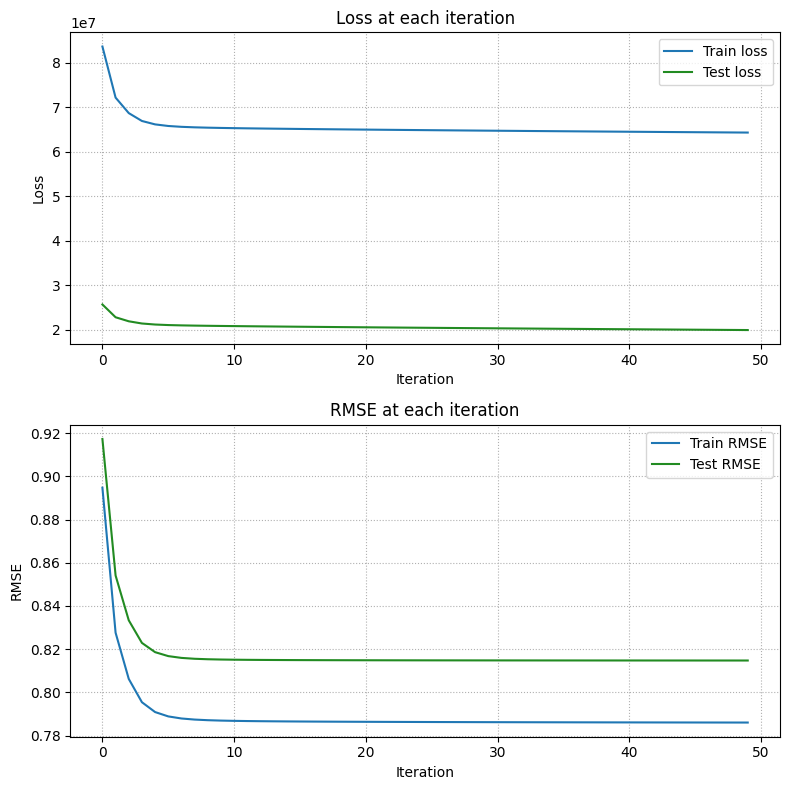

##################################################
############# Embedding Dimension 10 #############
#################### Results #####################
Train Loss: 54486409.91069452
Test Loss: 21611731.397757087
Train RMSE: 0.7028972290357606
Test RMSE: 0.7983267902903346
##################################################


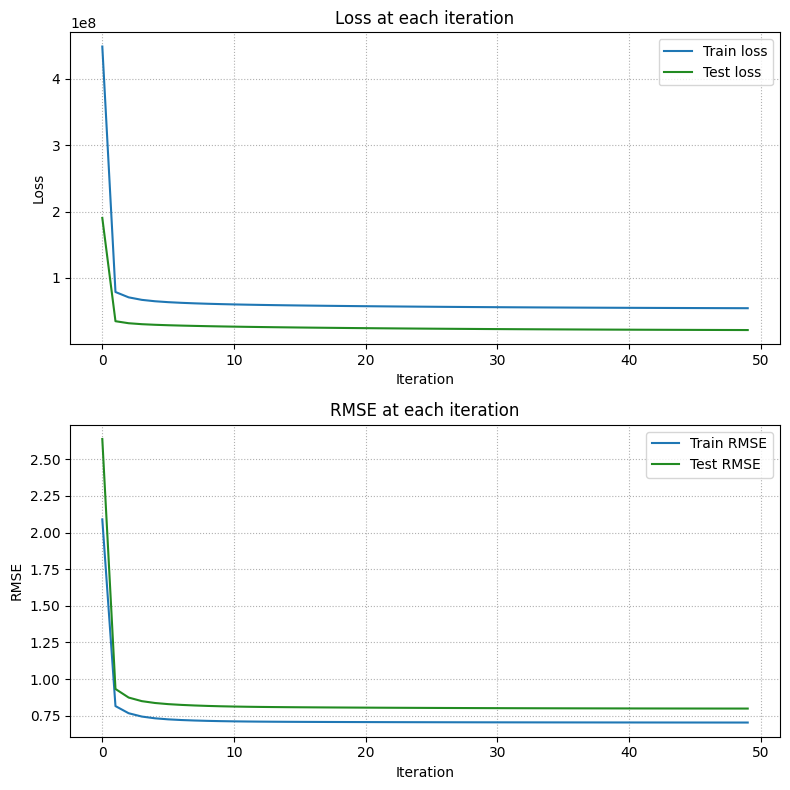

##################################################
############# Embedding Dimension 15 #############
#################### Results #####################
Train Loss: 55064937.09984082
Test Loss: 27535167.29277579
Train RMSE: 0.6685013333294805
Test RMSE: 0.8163124106581474
##################################################


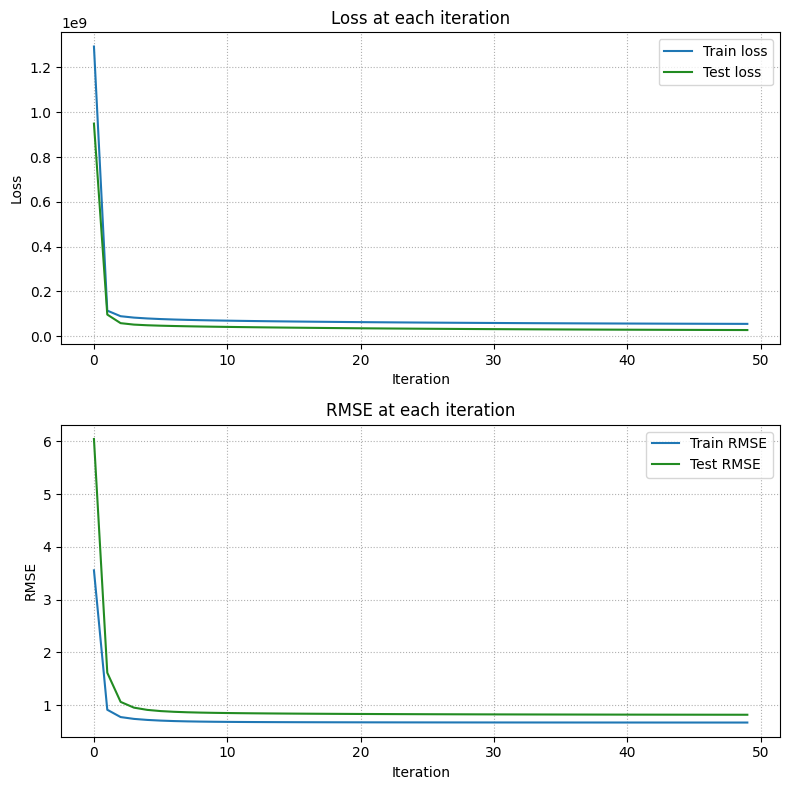

##################################################


In [6]:
for k in [2, 10, 15]:
    hyper_params = {'embedding_dim': k, **best_hyper_params}

    results = train_base(
        train,
        test,
        n_iter = 50,
        **hyper_params,
    )

    print(f" Embedding Dimension {k} ".center(50, "#"))

    display_results(results, f"../artifacts/plot/32m_training_{k}.pdf")

    print("#" * 50)

    save_params(
        f"../artifacts/model/32m_users_training_{k}", 
        hyper_params["r_lambda"],
        hyper_params["r_tau"],
        hyper_params["r_gamma"],
        metadata.idx_to_user_id,
        metadata.idx_to_movie_id,
        **results["embeddings"]
    )

#### Features Model Training

############# Embedding Dimension 2 ##############
#################### Results #####################
Train Loss: 64171474.911061026
Test Loss: 19819265.7182949
Train RMSE: 0.7860298795242074
Test RMSE: 0.814599812560146
##################################################


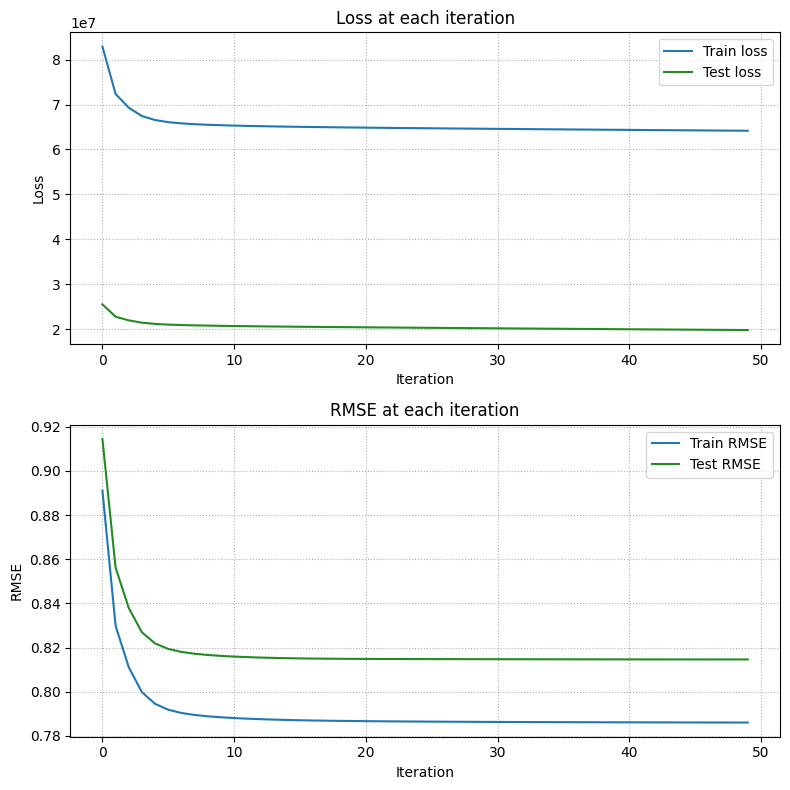

##################################################
############# Embedding Dimension 10 #############
#################### Results #####################
Train Loss: 52474604.4047539
Test Loss: 20697166.66237309
Train RMSE: 0.703113037821358
Test RMSE: 0.7975439992725122
##################################################


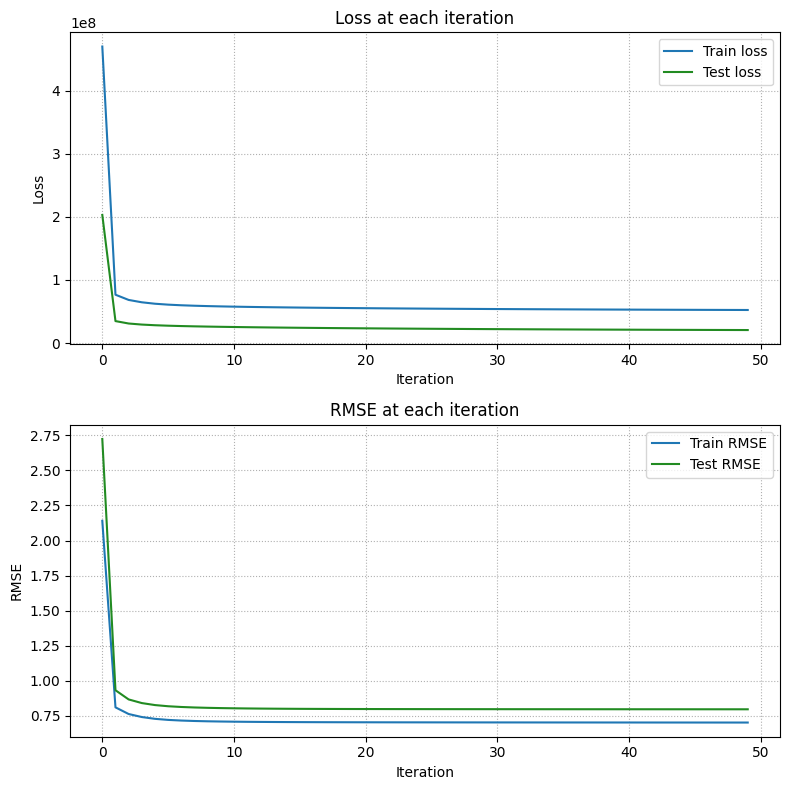

##################################################
############# Embedding Dimension 15 #############
#################### Results #####################
Train Loss: 49016992.42392878
Test Loss: 23932222.29961885
Train RMSE: 0.6679236173420465
Test RMSE: 0.8127653856139878
##################################################


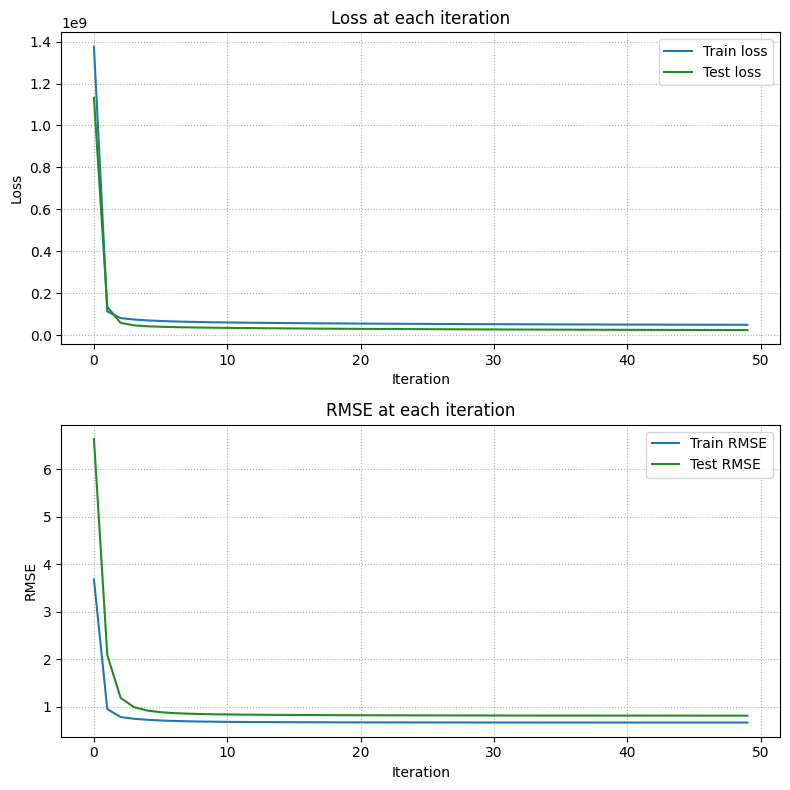

##################################################


In [8]:
for k in [2, 10, 15]:
    hyper_params = {'embedding_dim': k, **best_hyper_params}

    results = train_feat(
        train,
        test,
        metadata,
        n_iter = 50,
        **hyper_params,
    )

    print(f" Embedding Dimension {k} ".center(50, "#"))

    display_results(results, f"../artifacts/plot/32m_training_feat_{k}.pdf")

    print("#" * 50)

    save_params(
        f"../artifacts/model/32m_users_training_feat_{k}", 
        hyper_params["r_lambda"],
        hyper_params["r_tau"],
        hyper_params["r_gamma"],
        idx_to_user_id=metadata.idx_to_user_id,
        idx_to_movie_id=metadata.idx_to_movie_id,
        idx_to_feat_id=metadata.idx_to_feat_id,
        **results["embeddings"]
    )

#### Variational Model Training

############# Embedding Dimension 2 ##############
#################### Results #####################
Train Loss: -67011629.52878774
Test Loss: -22395943.64610706
Train RMSE: 0.7859305583215044
Test RMSE: 0.8143404755585074
##################################################


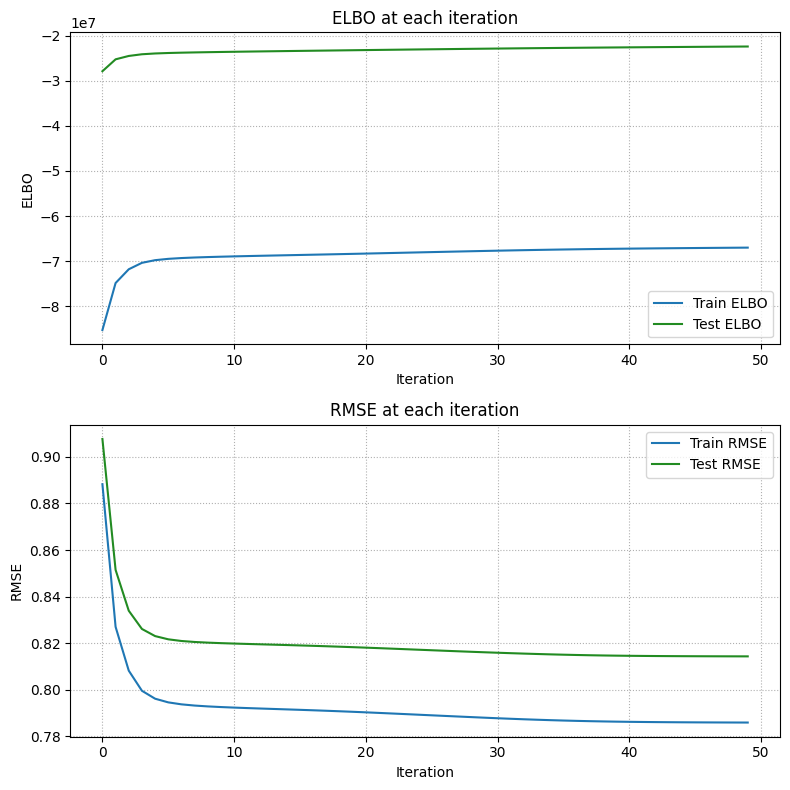

##################################################
############# Embedding Dimension 10 #############
#################### Results #####################
Train Loss: -66333248.551771045
Test Loss: -32527266.59862945
Train RMSE: 0.7026719884368663
Test RMSE: 0.7935423789282846
##################################################


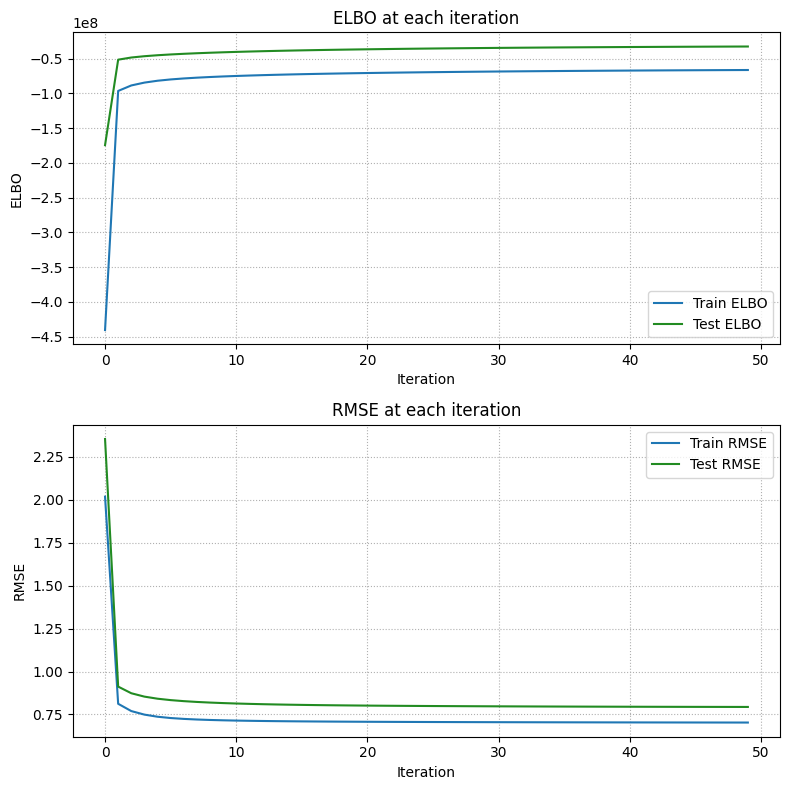

##################################################
############# Embedding Dimension 15 #############
#################### Results #####################
Train Loss: -74266974.16137534
Test Loss: -45076127.55292013
Train RMSE: 0.6695162678705011
Test RMSE: 0.8058478770638264
##################################################


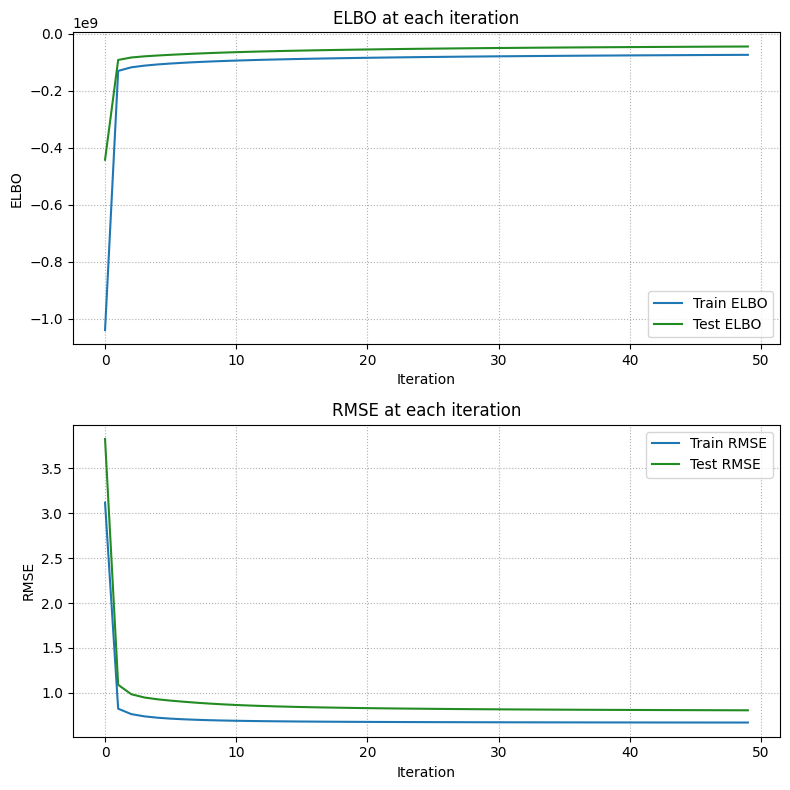

##################################################


In [10]:
for k in [2, 10, 15]:
    hyper_params = {'embedding_dim': k, **best_hyper_params}

    results = train_variational(
        train,
        test,
        n_iter = 50,
        **hyper_params,
    )

    print(f" Embedding Dimension {k} ".center(50, "#"))
    print(" Results ".center(50, "#"))
    print("Train Loss:", results["train_loss"][-1])
    print("Test Loss:", results["val_loss"][-1])
    print("Train RMSE:", results["train_rmse"][-1])
    print("Test RMSE:", results["val_rmse"][-1])
    print("#" * 50)

    fig, axs = plt.subplots(2, 1, figsize=(8, 8))

    axs[0].plot(results["train_loss"], label="Train ELBO")
    axs[0].plot(results["val_loss"], color="forestgreen", label="Test ELBO")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("ELBO")
    axs[0].set_title("ELBO at each iteration")
    axs[0].grid(True, linestyle=":")
    axs[0].legend()

    axs[1].plot(results["train_rmse"], label="Train RMSE")
    axs[1].plot(results["val_rmse"], color="forestgreen", label="Test RMSE")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("RMSE")
    axs[1].set_title("RMSE at each iteration")
    axs[1].grid(True, linestyle=":")
    axs[1].legend()

    plt.tight_layout()
    plt.savefig(f"../artifacts/plot/32m_variational_{k}.pdf", format="pdf", bbox_inches='tight')
    plt.show()

    print("#" * 50)

    save_variational(
        f"../artifacts/model/32m_variational_{k}", 
        hyper_params["r_lambda"],
        hyper_params["r_tau"],
        hyper_params["r_gamma"],
        idx_to_user_id=metadata.idx_to_user_id,
        idx_to_movie_id=metadata.idx_to_movie_id,
        **results["embeddings"]
    )

---